## EVALUATION NOTEBOOK - DEEP CHROMA

### Transsprition Results

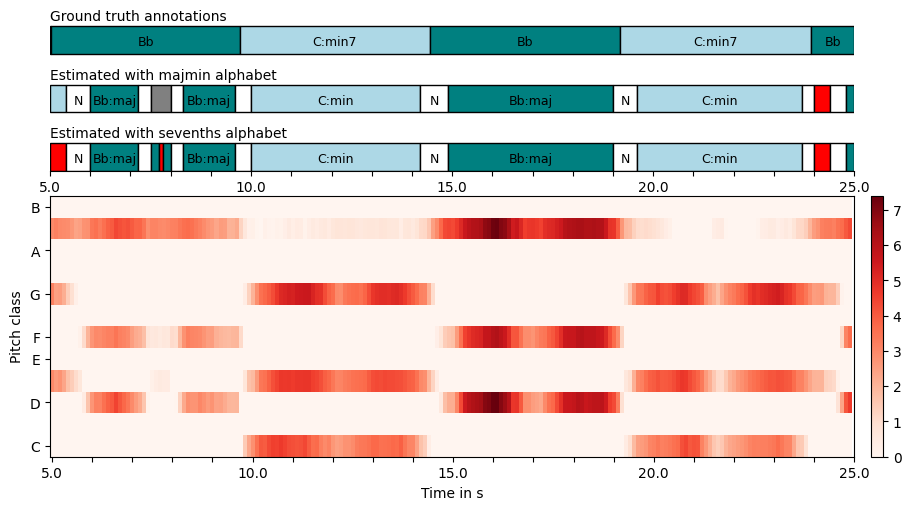

In [3]:
import matplotlib.pyplot as plt
from visualization import visualizationApp
%matplotlib inline
visualizationApp("/home/max/ET-TI/Masterarbeit/chord-recognition/results");
plt.ioff(); # interactive modoff

### Statistical Evaluation

Majmin DCP vs CPSS


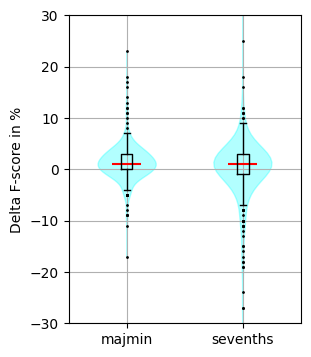

In [7]:
import visualization
import utils
import numpy as np
import matplotlib.pyplot as plt
from dataloader import OUTLIERS

def computeDeltaF(a,b,dataset="combined",alphabet="majmin"):
    if dataset == "combined":
        dataset = ["beatles","rwc_pop","rw","queen"]

    titles = [x.name for x in a if x.name not in OUTLIERS and x.dataset in dataset]
    if alphabet == "majmin":
        f_scores = [100*(x.majmin_f-y.majmin_f) for x,y in zip(a,b) if x.name not in OUTLIERS and x.dataset in dataset]
    else:
        f_scores = [100*(x.sevenths_f-y.sevenths_f) for x,y in zip(a,b) if x.name not in OUTLIERS and x.dataset in dataset]
    return titles, f_scores

results_a, datasets = visualization.load_results("results/deepchroma_cpss_vs_template.hdf5")
results_b, datasets = visualization.load_results("results/dcp_none.hdf5")

titles, delta_f_majmin = computeDeltaF(results_b,results_a,"combined")
titles, delta_f_sevenths = computeDeltaF(results_b,results_a,"combined","sevenths")
print("Majmin DCP vs CPSS")
fig,ax = plt.subplots(figsize=(3,4))
bodies,bplot = utils.create_violinplot(ax,[delta_f_majmin,delta_f_sevenths],["majmin","sevenths"],ylim=(-30,30))
ax.set_ylabel("Delta F-score in %")
ax.set_yticks(np.arange(-30,40,10));


### evaluation of stable chroma regions
The gating function is used  for evaluatuion

CD1_-_14_-_Don't_Pass_Me_By


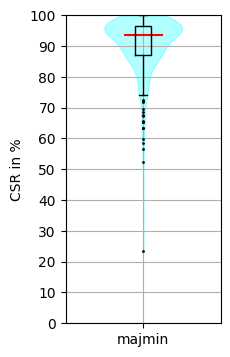

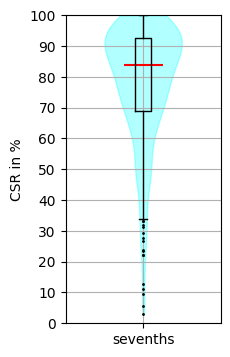

In [4]:
import h5py
import mir_eval
from dataloader import OUTLIERS,DATASETS
results = []

def evaluateStableRegions(ref_intervals,ref_labels,est_intervals,est_labels):
    # prepare estimated labels for evaluation
    est_intervals, est_labels = mir_eval.util.adjust_intervals(
                            est_intervals, est_labels, ref_intervals.min(),
                            ref_intervals.max(), mir_eval.chord.NO_CHORD,
                            mir_eval.chord.NO_CHORD)
    intervals,ref_labels,est_labels = mir_eval.util.merge_labeled_intervals(
                        ref_intervals, ref_labels, est_intervals, est_labels)
    
    # only compare stable regions -> skip No Chord labels
    durations = []
    labels = []
    gt = []
    for x,y,z in zip(intervals,est_labels,ref_labels):
        if y == "N" or z == "N":
            continue
        durations.append(x[1]-x[0])
        labels.append(y)
        gt.append(z)
    majmin = mir_eval.chord.weighted_accuracy(np.asarray(mir_eval.chord.majmin(gt, labels)), np.asarray(durations))
    sevenths_score = mir_eval.chord.weighted_accuracy(np.asarray(mir_eval.chord.sevenths(gt, labels)), np.asarray(durations))
    return majmin, sevenths_score

results = []
wcsr_majmin = []
wcsr_sevenths = []
with  h5py.File("results/deepchroma_cpss_vs_template.hdf5","r") as file:
    datasets = file.attrs.get("dataset",DATASETS)

    if datasets is None:
        raise KeyError("Corrupt result file! no datasets are specified in the header!")
    
    if not isinstance(datasets,list): # convert to list if necessary
        datasets = list(datasets)

    for grp_name in datasets:
        for subgrp_name in file[f"{grp_name}/"]:
            subgrp = file[f"{grp_name}/{subgrp_name}"]
            if subgrp.attrs.get("name") in OUTLIERS:
                continue
            ref_intervals = np.array(subgrp.get("ref_intervals"))
            ref_labels = [x.decode('utf-8') for x in subgrp.get("ref_labels")]
            est_intervals = np.array(subgrp.get("intervals_cpss"))
            est_labels = [x.decode('utf-8') for x in subgrp.get("labels_cpss")]
            gate = subgrp.get("gate")
            majmin,sevenths = evaluateStableRegions(ref_intervals,ref_labels,est_intervals,est_labels)
            wcsr_majmin.append(100 * majmin)
            wcsr_sevenths.append(100 * sevenths)
            if majmin < 0.5:
                print(subgrp.attrs.get("name"))
fig,ax = plt.subplots(figsize=(2,4))
bodies,bplot = utils.create_violinplot(ax,wcsr_majmin,["majmin"],ylim=(0,100))
ax.set_ylabel("CSR in %")
ax.set_yticks(np.arange(0,110,10));
fig,ax = plt.subplots(figsize=(2,4))
bodies,bplot = utils.create_violinplot(ax,wcsr_sevenths,["sevenths"],ylim=(0,100))
ax.set_ylabel("CSR in %")
ax.set_yticks(np.arange(0,110,10));

beatles
1.0,+/-1.0
rwc_pop
2.0,+/-3.0
rw
1.0,+/-2.0
queen
1.0,+/-2.0
combined
1.0,+/-2.0


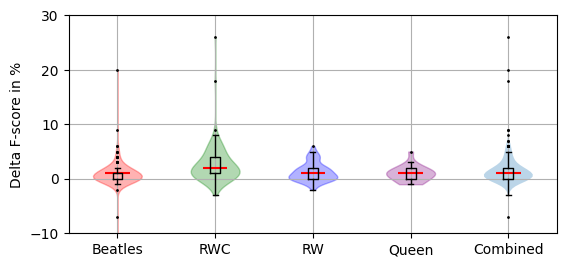

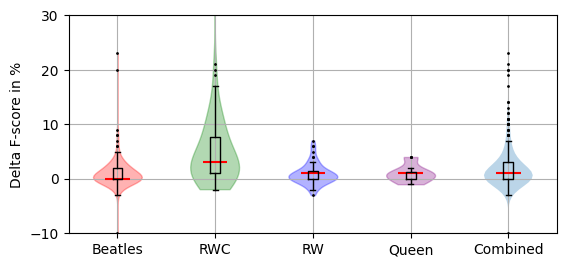

In [24]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
from dataloader import DATASETS
import utils

def plotDeltas(delta):
        fig, ax1 = plt.subplots(figsize=(5.5, 2.5))
        parts = ax1.violinplot(delta,showmeans=False, showmedians=True,
                showextrema=False)
        bplot = ax1.boxplot(delta,
                        showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
                        flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
                        widths=0.1)
        parts["cmedians"].set_color("red")
        for x,color in zip(parts["bodies"],['r','g','b','purple']):
                x.set_color(color)
        xlabels = ["Beatles","RWC","RW","Queen","Combined"]
        ax1.set_ylabel("Delta F-score in %")
        ax1.set_yticks(np.arange(-30,40,10))
        ax1.set_ylim(-10,30)
        ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
        ax1.set_xlim(0.5, len(xlabels) + 0.5);
        ax1.grid("on")
        fig.tight_layout(pad=0.1)
        return fig

def load_results(path="results/deepchroma_cpss_vs_template.hdf5",model="cpss"):
    data = {}
    combined_majmin_f = []
    combined_sevenths_f = []
    with  h5py.File(path,"r") as file:
        for grp_name in DATASETS:
            dset_majmin_f = []
            dset_sevenths_f = []
            for subgrp_name in file[f"{grp_name}/"]:
                subgrp = file[f"{grp_name}/{subgrp_name}"]
                dset_majmin_f.append(subgrp.attrs.get(f"{model}_majmin_f"))
                dset_sevenths_f.append(subgrp.attrs.get(f"{model}_sevenths_f"))
            # append dataset to combined results
            data[grp_name] = (dset_majmin_f, dset_sevenths_f)
            combined_majmin_f += dset_majmin_f
            combined_sevenths_f += dset_sevenths_f
        data["combined"] = (combined_majmin_f, combined_sevenths_f)
    return data

data_cpss = load_results(model="cpss")
data_templates = load_results(model="templates")
delta_majmin = []
delta_sevenths = []
for dataset,x,y in zip(data_cpss.keys(), data_cpss.values(), data_templates.values()):
    majmin_cpss_f, sevenths_cpss_f = x
    majmin_templ_f, sevenths_templ_f = y
    print(dataset)
    delta_majmin_f = [100*(x-y) for x,y in zip(majmin_cpss_f, majmin_templ_f)]
    delta_sevenths_f = [100*(x-y) for x,y in zip(sevenths_cpss_f, sevenths_templ_f)]
    print(f"{np.median(delta_majmin_f):0.1f},+/-{np.subtract(*np.percentile(delta_majmin_f, [75, 25])):0.1f}")
    delta_majmin.append(delta_majmin_f)
    delta_sevenths.append(delta_sevenths_f)

plotDeltas(delta_majmin);
plotDeltas(delta_sevenths);